In [1]:
%pip install altair pandas plotly pygal cairosvg ruamel.yaml PrefixedUnit

ERROR: Could not find a version that satisfies the requirement PrefixedUnit (from versions: none)
ERROR: No matching distribution found for PrefixedUnit
Note: you may need to restart the kernel to use updated packages.


In [2]:
"""
The metrics are from papi
"""
import pandas as pd
import altair as alt
import numpy as np
import plotly.express as px

data = pd.read_csv("example_omp18_papi.csv")
data1 = pd.read_csv("example_omp1_papi.csv")

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 30)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics

font = {'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

class ComplexRadar():
    def _invert(self, x, limits):
        return limits[1] - (x - limits[0])

    def _scale_data(self, data, ranges):
        """scales data[1:] to ranges[0],
        inverts if the scale is reversed"""
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            assert (y1 <= d <= y2) or (y2 <= d <= y1)
        x1, x2 = ranges[0]
        d = data[0]
        if x1 > x2:
            d = self._invert(d, (x1, x2))
            x1, x2 = x2, x1
        sdata = [d]
        for d, (y1, y2) in zip(data[1:], ranges[1:]):
            if y1 > y2:
                d = self._invert(d, (y1, y2))
                y1, y2 = y2, y1
            sdata.append((d-y1) / (y2-y1) 
                         * (x2 - x1) + x1)
        return sdata
    def create_ranges(self):
        # we need to change this formula here somehow
        """
            maybe scale them some oyher way
        """
        return [(self.data[x].min(), self.data[x].max()) for x in self.labels] 
        
    def __init__(self, fig, labels, data, functions_to_plot,
                 n_ordinate_levels=6):
        # calculate the ranges and the labels
        self.functions_to_plot = functions_to_plot
        
        self.labels = labels
        self.data = data
        self.ranges = self.create_ranges()
        ranges = self.ranges
        
        angles = np.arange(0, 360, 360./len(labels))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(labels))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=labels, fontweight='bold', fontsize=15)
        axes[0].tick_params(pad=40)
        
        
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
            
        for i, ax in enumerate(axes):
            grid = np.linspace(*self.ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if self.ranges[i][0] > self.ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ax = axes[0]

    def _plot(self, data, label):
        sdata = self._scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], label=label)

    def plot(self):
        lines = []
        for label in self.functions_to_plot:
            vars_plt = self.data.loc[self.data['Function'] == label][self.labels].values.tolist()[0]
            # not sure here why the output is not flat
            self._plot(vars_plt, label)
            lines.append(vars_plt)
        self.ax.legend()

    def fill(self, data, *args, **kw):
        sdata = self._scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

# Radar of instructions executed, cache misses,
# plus DP_OPS vs. VEC_DP. Time maybe too, if you can scale it cleanly.      

# which one is the cache miss?
# what functions to plot
# how we may plot the function?  function name over the graph


,id,%Time,WallTime,#Hits,IPC,Cycles/s,Instr/s,Flops/s,TOT_CYC,TOT_INS,L1_DCM,L2_DCM,L3_TCM,L1_ICM,VEC_DP,DP_OPS,VEC_SP,SP_OPS,TLB_DM,TLB_IM,Function,Scope,File
0,1,8.7,5.900,118,1.28,2003,2571.0,1967.0,11817.0,15167.0,642.0,574.0,108.000,3.271,3807.0,7794.0,0.366,0.366,19.997,0.125,save_fluxes,USER,radiation_save.F90
1,2,8.3,5.597,112,1.20,2003,2414.0,2264.0,11209.0,13506.0,514.0,473.0,100.832,2.367,3377.0,9293.0,0.720,0.720,11.498,0.102,solver_mcica_lw,USER,radiation_mcica_lw.F90
2,3,7.9,5.350,107,1.53,2003,3073.0,3096.0,10714.0,16441.0,611.0,583.0,66.099,3.514,4319.0,12241.0,0.425,0.425,8.492,0.124,rrtm_taumol3,USER,rrtm_taumol3.F90
3,4,5.8,3.900,78,1.45,2003,2903.0,2198.0,7811.0,11320.0,471.0,428.0,53.001,2.493,2689.0,5882.0,0.262,0.262,17.227,89228.000,solver_homogeneous_sw,USER,radiation_homogeneous_sw.F90
4,5,4.1,2.800,56,1.30,2003,2600.0,2047.0,5608.0,7280.0,285.0,265.0,52.057,1.498,1785.0,3945.0,0.113,0.113,9.237,55798.000,rrtm_kgb7,USER,rrtm_kgb7.F90


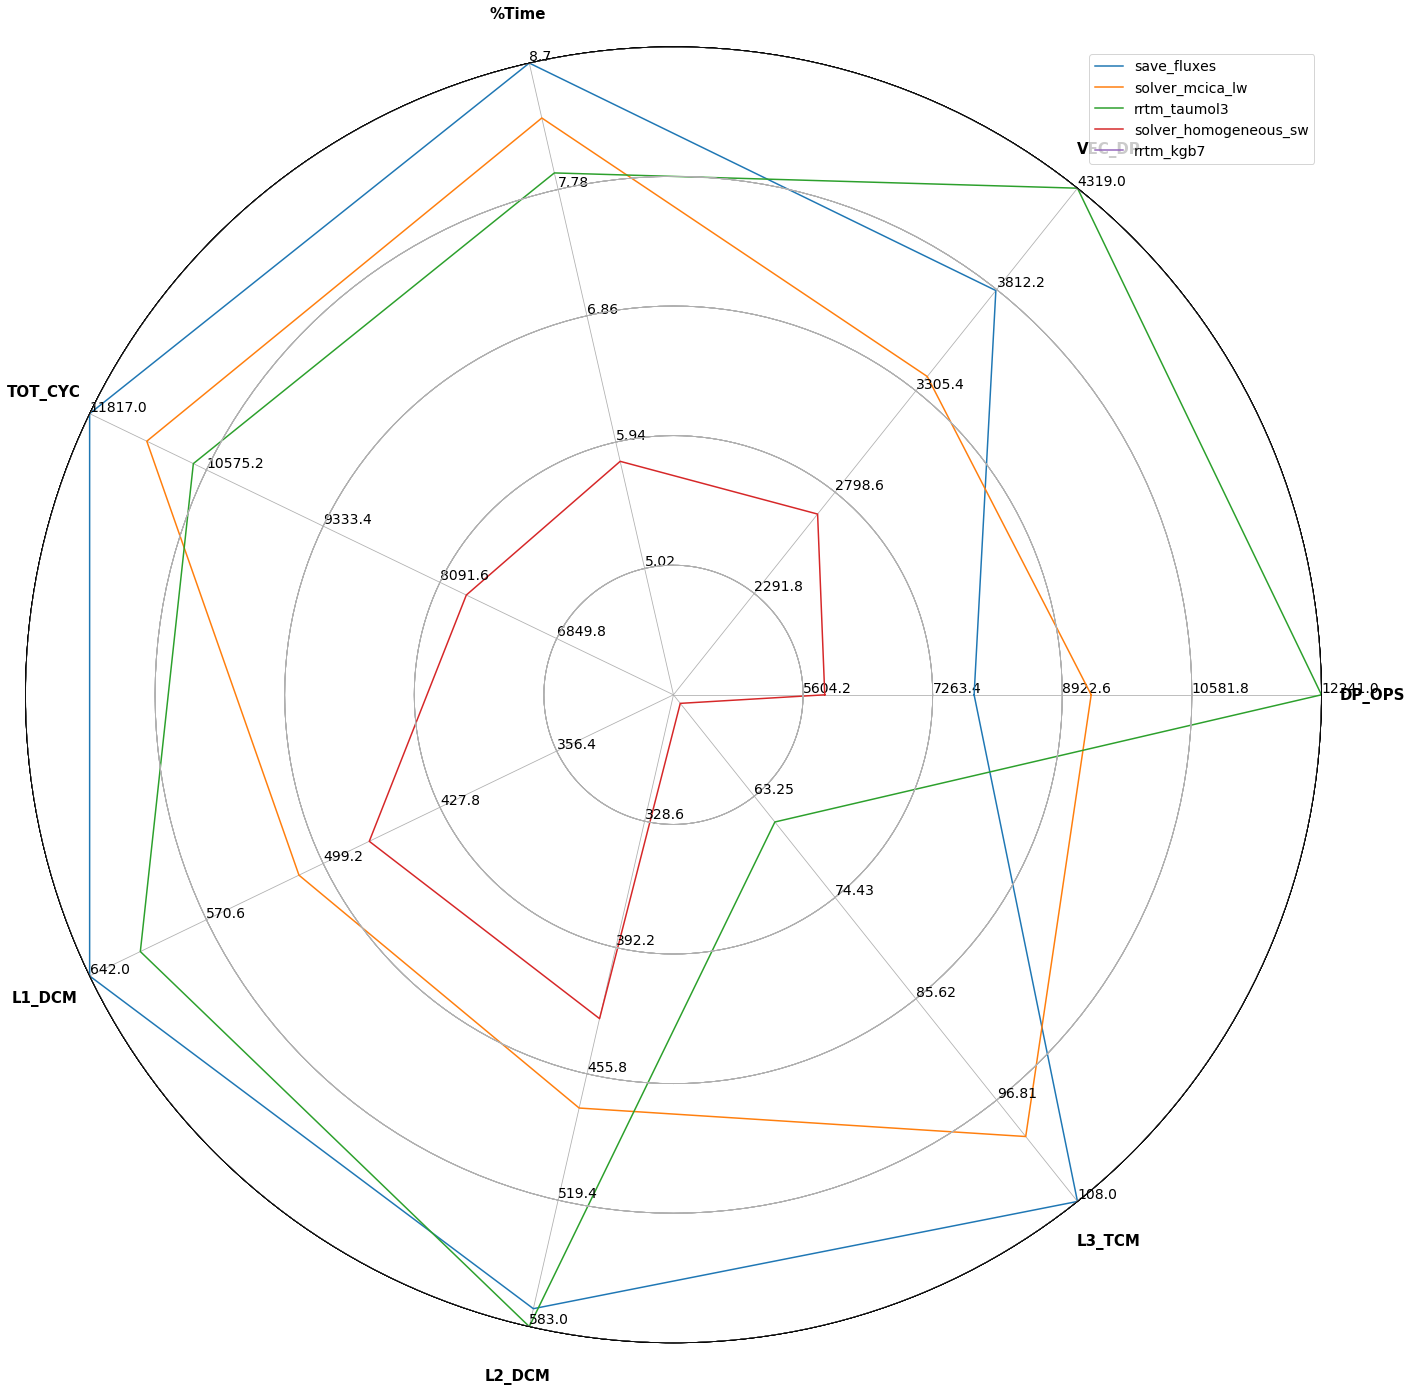

In [4]:
display(data.head(5))
data = data.head(5)
functions_to_plot = data.head(5)["Function"].to_list()
labels = ['DP_OPS', 'VEC_DP', '%Time', 'TOT_CYC', 'L1_DCM', 'L2_DCM', 'L3_TCM']


fig1 = plt.figure(figsize=(20, 20))
radar = ComplexRadar(fig1, labels, data, functions_to_plot)
radar.plot()


In [6]:
import plotly.graph_objects as go
import pandas as pd


df = pd.read_csv("example_omp1_papi.csv")
# plot the function from the example_omp18_papi.csv
functions_to_plot = df.head(5)["Function"].to_list()

df_call = pd.read_json("callgraph.json")
display(df_call.head())
df = df.loc[df["Function"].isin(functions_to_plot)]
primary_feature = 'WallTime'
features = ["Function", "WallTime"]
df = df[features]
df['parent'] = primary_feature

fig = go.Figure(go.Sunburst(
        labels = df['Function'],
        customdata = df,
        values = df[primary_feature],
        parents = df.parent))

fig.update_layout(uniformtext=dict(minsize=10, mode='hide'))
fig.show()


ValueError: arrays must all be same length